# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [1]:
import os
import time
import joblib
import requests
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from azureml.widgets import RunDetails
from azureml.core import Workspace, Experiment
from azureml.core.model import Model, InferenceConfig
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.environment import Environment
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.webservice import AciWebservice
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.train.automl import AutoMLConfig

print("SDK version:", azureml.core.VERSION)

SDK version: 1.20.0


In [2]:
time.strftime('%Y-%m-%d %H:%M:%S')

'2021-02-10 14:33:59'

In [3]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

quick-starts-ws-138398
aml-quickstarts-138398
southcentralus
1b944a9b-fdae-4f97-aeb1-b7eea0beac53


Set up a compute instance to train the model.

In [4]:
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "auto-ml")
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 2)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

compute_names = [cn for cn in ws.compute_targets if cn in [compute_name,'auto-ml','aml-compute']]

if compute_names:
    compute_target = ws.compute_targets[compute_names[0]]
    if compute_target and type(compute_target) is AmlCompute:
        print('Using existing compute target: ' + compute_names[0])
else:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size=vm_size,
        min_nodes=compute_min_nodes,
        max_nodes=compute_max_nodes
    )
    compute_target = ComputeTarget.create(ws, compute_name, compute_config)

## Dataset

### Overview
We will be using the Wine Quality dataset made accessible [here](https://archive.ics.uci.edu/ml/datasets/wine+quality).

The dataset contains the physicochemical properties of 1599 red wine samples. The data includes, in column order: `fixed acidity`, `volatile acidity`, `citric acid`, `residual sugar`, `chlorides`, `free sulfur dioxide`, `total sulfur dioxide`, `density`, `pH`, `sulphates`, `alcohol`, and the final column is the target variable, `quality` (score between 0 and 10).

We will carry out an AutoML regression analysis on this dataset to predict the quality of a particular sample of wine from measured properties.

In [5]:
data_file_source = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
ds_data = TabularDatasetFactory.from_delimited_files(
    path=data_file_source,
    separator=';'
)
ds_data = ds_data.register(
    workspace=ws,
    name='wine_quality_data',
    description='Wine Quality data from ' + data_file_source
)
df = ds_data.to_pandas_dataframe()
x = df.drop(columns='quality')
y = df['quality']

Split the dataset into a training set and a test set, using 70% of the dataset for training.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)
datastore = ws.get_default_datastore()
x_train.assign(target=y_train).to_csv('df_train.csv', index=False)
datastore.upload_files(['df_train.csv'], overwrite=True)
train_ds = TabularDatasetFactory.from_delimited_files((datastore, 'df_train.csv'))

Uploading an estimated of 1 files
Uploading df_train.csv
Uploaded df_train.csv, 1 files out of an estimated total of 1
Uploaded 1 files


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [7]:
experiment_name = 'winequality-automl'
project_folder = './winequality-automl-pipeline'
experiment=Experiment(ws, experiment_name)

Create AutoML settings object

In [8]:
aml_regression_metrics = [
    'spearman_correlation',
    'normalized_root_mean_squared_error',
    'r2_score',
    'normalized_mean_absolute_error'
]

automl_settings = {
    'experiment_timeout_minutes': 15,
    'max_concurrent_iterations': 5,
    'n_cross_validations': 5,
    'primary_metric' : 'normalized_root_mean_squared_error'
}
automl_config = AutoMLConfig(
    compute_target=compute_target,
    task='regression',
    training_data=train_ds,
    label_column_name='target',
    path=project_folder,
    enable_early_stopping=True,
    featurization='auto',
    debug_log='automl_errors.log',
    **automl_settings
)

Create pipeline and AutoMLStep

In [9]:
compute_target.wait_for_completion(show_output=True)

Creating
Succeeded........................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [10]:
automl_run = experiment.submit(config=automl_config)
automl_run

Running on remote.


Experiment,Id,Type,Status,Details Page,Docs Page
winequality-automl,AutoML_09d54a55-51c6-499f-a116-05e9e7189e72,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


## Run Details

In [11]:
RunDetails(automl_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [12]:
automl_run.wait_for_completion()

{'runId': 'AutoML_09d54a55-51c6-499f-a116-05e9e7189e72',
 'target': 'auto-ml',
 'status': 'Completed',
 'startTimeUtc': '2021-02-10T14:36:46.448406Z',
 'endTimeUtc': '2021-02-10T14:59:56.430023Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'auto-ml',
  'AMLSettingsJsonString': '{"path":null,"name":"winequality-automl","subscription_id":"1b944a9b-fdae-4f97-aeb1-b7eea0beac53","resource_group":"aml-quickstarts-138398","workspace_name":"quick-starts-ws-138398","region":"southcentralus","compute_target":"auto-ml","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validations":5,"y_min

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [13]:
# Retrieve and save your best automl model.
automl_best_run = automl_run.get_best_child()
automl_best_run_metrics = automl_best_run.get_metrics()

print('Best Run Id: ', automl_best_run.id)
[(k,round(v,4)) if type(v)!=str else (k,v) for k,v in automl_best_run_metrics.items()]

Best Run Id:  AutoML_09d54a55-51c6-499f-a116-05e9e7189e72_38


[('normalized_median_absolute_error', 0.064),
 ('median_absolute_error', 0.3199),
 ('r2_score', 0.4403),
 ('normalized_mean_absolute_error', 0.0895),
 ('mean_absolute_percentage_error', 8.2792),
 ('spearman_correlation', 0.6714),
 ('root_mean_squared_error', 0.6036),
 ('explained_variance', 0.4483),
 ('root_mean_squared_log_error', 0.094),
 ('mean_absolute_error', 0.4475),
 ('normalized_root_mean_squared_error', 0.1207),
 ('normalized_root_mean_squared_log_error', 0.1159),
 ('residuals',
  'aml://artifactId/ExperimentRun/dcid.AutoML_09d54a55-51c6-499f-a116-05e9e7189e72_38/residuals'),
 ('predicted_true',
  'aml://artifactId/ExperimentRun/dcid.AutoML_09d54a55-51c6-499f-a116-05e9e7189e72_38/predicted_true')]

In [14]:
model = automl_run.register_model(
    description='Wine quality AutoML best model',
    tags={'area': 'wine-quality'}
)

In [15]:
model.download()

'model.pkl'

In [16]:
local_model = joblib.load('model.pkl')

In [17]:
local_model.steps[1][1].get_params()

{'estimators': [('0',
   Pipeline(memory=None,
            steps=[('maxabsscaler', MaxAbsScaler(copy=True)),
                   ('lightgbmregressor',
                    LightGBMRegressor(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split', learning_rate=0.1,
                                      max_depth=-1, min_child_samples=20,
                                      min_child_weight=0.001, min_split_gain=0.0,
                                      n_estimators=100, n_jobs=1, num_leaves=31,
                                      objective=None, random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0, verbose=-1))],
            verbose=False)),
  ('34',
   Pipeline(memory=None,
            steps=[('sta

In [18]:
y_pred = local_model.predict(x_test)

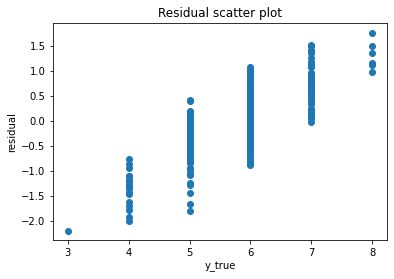

In [19]:
plt.scatter(y_test, y_test-y_pred)
plt.title('Residual scatter plot')
plt.xlabel('y_true')
plt.ylabel('residual')
plt.show()

## Model Deployment

In [20]:
env = Environment.get(workspace=ws, name='AzureML-AutoML')

inference_config = InferenceConfig(
    entry_script='score_automl.py',
    environment=env
)
aci_config = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=1
)

In [21]:
service_name = 'wine-quality-predictor-aml'

service = Model.deploy(
    workspace=ws,
    name=service_name,
    models=[model],
    inference_config=inference_config,
    deployment_config=aci_config,
    overwrite=True
)

In [22]:
service.wait_for_deployment(show_output=True)
print("State: " + service.state)
print("Scoring URI: " + service.scoring_uri)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.....................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
State: Healthy
Scoring URI: http://b7cd6463-b056-4b3a-859a-2e8ceb5e4423.southcentralus.azurecontainer.io/score


Send a request to the deployed web service

In [23]:
# select a few random rows from the test set to score
random_data = df.sample(5, random_state=42).values
random_data.shape

(5, 12)

In [24]:
x_test_run = random_data[:,:-1].tolist()
y_test_run = random_data[:,-1].tolist()

input_data = "{\"data\": " + str(x_test_run) + "}"
headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
print("input data:", input_data)
print("label:", y_test_run)
print("prediction:", resp.text)

POST to url http://b7cd6463-b056-4b3a-859a-2e8ceb5e4423.southcentralus.azurecontainer.io/score
input data: {"data": [[7.7, 0.56, 0.08, 2.5, 0.114, 14.0, 46.0, 0.9971, 3.24, 0.66, 9.6], [7.8, 0.5, 0.17, 1.6, 0.082, 21.0, 102.0, 0.996, 3.39, 0.48, 9.5], [10.7, 0.67, 0.22, 2.7, 0.107, 17.0, 34.0, 1.0004, 3.28, 0.98, 9.9], [8.5, 0.46, 0.31, 2.25, 0.078, 32.0, 58.0, 0.998, 3.33, 0.54, 9.8], [6.7, 0.46, 0.24, 1.7, 0.077, 18.0, 34.0, 0.9948, 3.39, 0.6, 10.6]]}
label: [6.0, 5.0, 6.0, 5.0, 6.0]
prediction: [5.35, 5.04, 5.19, 5.29, 5.91]


In [25]:
time.strftime('%Y-%m-%d %H:%M:%S')

'2021-02-10 15:03:45'

TODO: In the cell below, print the logs of the web service and delete the service

In [26]:
logs = service.get_logs()
for line in logs.split('\n'):
    print(line)

2021-02-10T15:03:25,373777168+00:00 - nginx/run 
2021-02-10T15:03:25,373777468+00:00 - iot-server/run 
/usr/sbin/nginx: /azureml-envs/azureml_7ade26eb614f97df8030bc480da59236/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_7ade26eb614f97df8030bc480da59236/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_7ade26eb614f97df8030bc480da59236/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_7ade26eb614f97df8030bc480da59236/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_7ade26eb614f97df8030bc480da59236/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
2021-02-10T15:03:25,375284814+00:00 - rsyslog/run 
2021-02-10T15:03:25,373993375+00:00 - gunicorn/run 
rsyslogd

In [27]:
try:
    service.delete()
    compute_target.delete()
except:
    print('Already deleted')
else:
    compute_target.wait_for_completion(show_output=False, is_delete_operation=True)

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"

Provisioning operation finished, operation "Succeeded"
